## Description of Variables
The dataset contains 6366 observations of 9 variables:

* rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
* age: woman's age
* yrs_married: number of years married
* children: number of children
* religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* occupation_husb: husband's occupation (same coding as above)
* affairs: time spent in extra-marital affairs

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [6]:
#pull the data out of statsmodel's example datasets
dta = sm.datasets.fair.load_pandas().data

#generate affair binary variable by the following: 
#if dta['affiars'], which is the time spent in extra-marital affiars, is >0
#create boolean variable, and force it to the data type int, making true = 1
dta['affair'] = (dta.affairs > 0).astype(int)

In [7]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [8]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


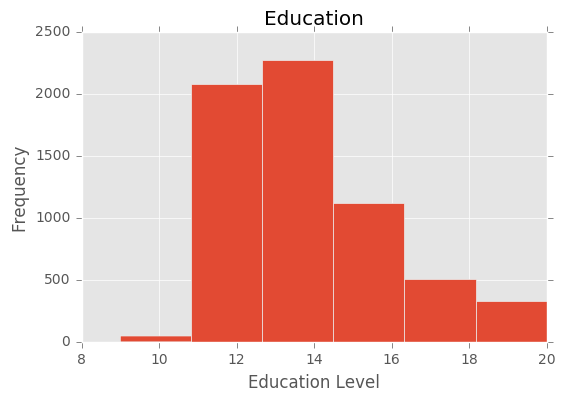

In [22]:
dta.educ.hist(bins = 6)
plt.title('Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

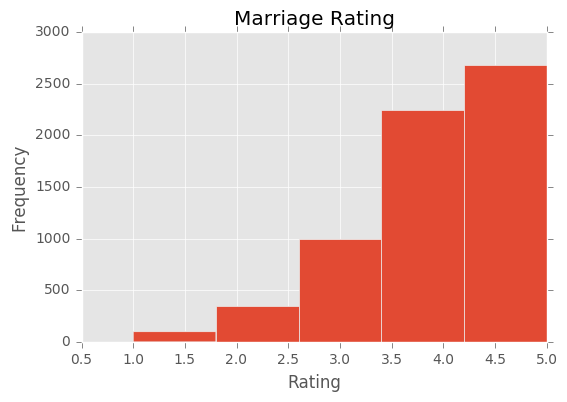

In [23]:
dta.rate_marriage.hist(bins = 5)
plt.title('Marriage Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

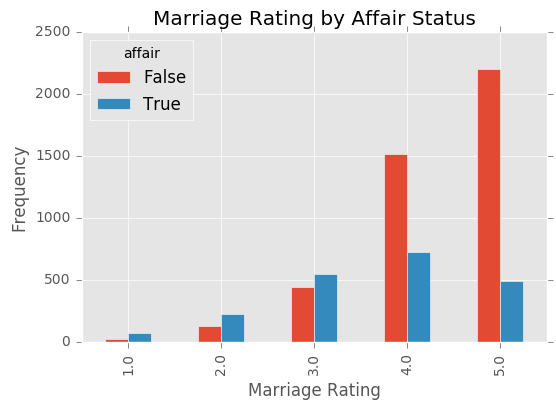

In [62]:
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

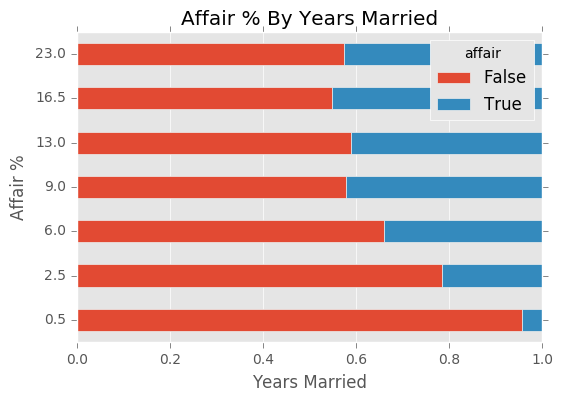

In [67]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), 
                       axis = 0).plot(kind='barh', stacked = True)#,
                                     #legend=False)
plt.title('Affair % By Years Married')
plt.xlabel('Years Married')
plt.ylabel('Affair %')

In [33]:
#Create 2x dataframes from the original dataset, but also convert categorical
#variables into something that scikit-learn can comprehend
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                   religious + educ + C(occupation) + C(occupation_husb)',
                   dta, return_type='dataframe')
print(type(y))
print(type(X))
print(X.columns)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Index([u'Intercept', u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]',
       u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]',
       u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]',
       u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]',
       u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]',
       u'rate_marriage', u'age', u'yrs_married', u'children', u'religious',
       u'educ'],
      dtype='object')


In [35]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})
print(X.columns)

Index([u'Intercept', u'occ_2', u'occ_3', u'occ_4', u'occ_5', u'occ_6',
       u'occ_husb_2', u'occ_husb_3', u'occ_husb_4', u'occ_husb_5',
       u'occ_husb_6', u'rate_marriage', u'age', u'yrs_married', u'children',
       u'religious', u'educ'],
      dtype='object')


In [34]:
#change y to a 1D Numpy array for scikit-learn
y = np.ravel(y)
print(type(y))

<type 'numpy.ndarray'>


## Acutal Logistic Regression

In [37]:
#instantiate model
model = LogisticRegression()

#fit model with X and y
model = model.fit(X,y)

#check accuracy of the model
model.score(X,y)

0.72588752748978946

In [ ]:
#This means that we have 73% accuracy on our model

In [38]:
#Compare model accuracy to base statistics
y.mean()

0.32249450204209867

In [ ]:
#I could achieve 68% (100-32) accuracy by assigning everyone to the 'no' class,
#so my logistic model is performing slightly better at 72.5% accuracy

In [39]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.48988355758]
1,occ_2,[0.188045595567]
2,occ_3,[0.498925975053]
3,occ_4,[0.250647053833]
4,occ_5,[0.838983051061]
5,occ_6,[0.833921371063]
6,occ_husb_2,[0.190546648076]
7,occ_husb_3,[0.297744501881]
8,occ_husb_4,[0.161319242344]
9,occ_husb_5,[0.18768293177]


In [ ]:
#Increases in marriage rating and religiousness correspond to a decrease in the 
#likelihood of having an affair. For both the wife's occupation and the 
#husband's occupation, the lowest likelihood of having an affair corresponds 
#to the baseline occupation (student), since all of the dummy coefficients are 
#positive.

## Splitting into Test/Train

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
#predict class labels for the test set
prediction = model2.predict(X_test)
print(prediction)

[ 1.  0.  0. ...,  0.  0.  0.]


In [43]:
#Generate probabilities for predictions
pred_proba = model2.predict_proba(X_test)
print(pred_proba)
#[probability of predicting 0 \t probability of predicting 1]

[[ 0.3514255   0.6485745 ]
 [ 0.9095254   0.0904746 ]
 [ 0.72576645  0.27423355]
 ..., 
 [ 0.55736907  0.44263093]
 [ 0.81213878  0.18786122]
 [ 0.74729574  0.25270426]]


In [45]:
#evaluation metrics
print(metrics.accuracy_score(y_test, prediction))
print(metrics.roc_auc_score(y_test, pred_proba[:,1]))

0.729842931937
0.74596198609


In [ ]:
#Neither of these are wildly different than our original predictive accuracy
#of 73%

In [49]:
print(metrics.confusion_matrix(y_test, prediction))
#1910 responses
#            Pred No             Pred Yes
#actual No   1169(trueNeg)       134(FalsePos)
#actual yes  382 (falseNeg)      225(truePos)

#Type 1 Error = False Positive: 134 // 0.070157
#Type 2 Error = False Negative: 382 // 0.2
#Accuracy (TP+TN)/Total: 72.98429
#Misclassification Rate (FP+FN)/Total (1-Accuracy): .270157
#False Positive Rate: (FP/actual no): .1028396
#Specificity (accuratly predicts no) TN/actual No: .8971604
#Precision (TP/Predicted Yes): .6267409
#Prevalance(actual yes/total): .317801

[[1169  134]
 [ 382  225]]


In [48]:
print(metrics.classification_report(y_test, prediction))
#Precision: see above
#Recall: true positive rate (225/225+382)
#f1-score: weighted average of recall and precision

             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



## Performing Cross Validation

In [51]:
#with 10 folds
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv = 10)

print(scores)
print('*'*75)
print(scores.mean())

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
***************************************************************************
0.724163068551


## Predicting Probability for a single instance

In [60]:
#Mine with made-up subjective ratings!
wife = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 30, 4, 0, 3, 20])
model.predict_proba(wife)
#predicts 23.73% chance my wife will have an affair!!

C:\Users\ajwil\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.76274339,  0.23725661]])

### Next Steps
There are many different steps that could be tried in order to improve the model:

* including interaction terms
* removing features
* regularization techniques
* using a non-linear model